<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/layout-lm-v3-works/02_document_classification_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [1]:
!pip install -qqq transformers==4.25.1 --progress-bar off
!pip install -qqq pytorch-lightning==1.8.6 --progress-bar off
!pip install -qqq imgkit==1.2.3 --progress-bar off
!pip install -qqq easyocr==1.6.2 --progress-bar off
!pip install -qqq Pillow==9.4.0 --progress-bar off
!pip install -qqq --upgrade --no-cache-dir gdown

In [ ]:
%%bash

# https://www.odoo.com/forum/help-1/wkhtmltopdf-how-do-i-install-0-12-5-1-the-one-odoo-needs-on-ubuntu-20-04-177412
# https://askubuntu.com/questions/1403619/mongodb-install-fails-on-ubuntu-22-04-depends-on-libssl1-1-but-it-is-not-insta
wget http://archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.0g-2ubuntu4_amd64.deb
sudo dpkg -i ./libssl1.1_1.1.0g-2ubuntu4_amd64.deb
rm -i libssl1.1_1.1.0g-2ubuntu4_amd64.deb

In [ ]:
%%bash
wget -q https://github.com/wkhtmltopdf/packaging/releases/download/0.12.6-1/wkhtmltox_0.12.6-1.bionic_amd64.deb
cp wkhtmltox_0.12.6-1.bionic_amd64.deb /usr/bin
apt -qq install /usr/bin/wkhtmltox_0.12.6-1.bionic_amd64.deb

In [4]:
!gdown 1tMZXonmajLPK9zhZ2dt-CdzRTs5YfHy0
!unzip -q financial-documents.zip
!mv "TableClassifierQuaterlyWithNotes" "documents"

Downloading...
From: https://drive.google.com/uc?id=1tMZXonmajLPK9zhZ2dt-CdzRTs5YfHy0
To: /content/financial-documents.zip
100% 3.10M/3.10M [00:00<00:00, 83.6MB/s]


In [45]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.model_selection import train_test_split
import imgkit
import easyocr
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
import json
from typing import List
import torchvision.transforms as T
from torchmetrics import Accuracy
from huggingface_hub import notebook_login
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

## Data

In [6]:
list(Path("documents").glob("*"))

[PosixPath('documents/Notes'),
 PosixPath('documents/Income Statement'),
 PosixPath('documents/Others'),
 PosixPath('documents/Cash Flow'),
 PosixPath('documents/Balance Sheets')]

In [7]:
for dir in Path("documents").glob("*"):
  dir.rename(str(dir).lower().replace(" ", "_"))

In [8]:
list(Path("documents").glob("*"))

[PosixPath('documents/notes'),
 PosixPath('documents/balance_sheets'),
 PosixPath('documents/others'),
 PosixPath('documents/cash_flow'),
 PosixPath('documents/income_statement')]

In [9]:
from os.path import exists
for dir in Path("documents").glob("*"):
  image_dir = Path(f"images/{dir.name}")
  image_dir.mkdir(exist_ok=True, parents=True)

In [10]:
list(Path("images").glob("*"))

[PosixPath('images/notes'),
 PosixPath('images/balance_sheets'),
 PosixPath('images/others'),
 PosixPath('images/cash_flow'),
 PosixPath('images/income_statement')]

## HTML to PNG

In [11]:
def convert_html_to_image(html_path: Path, images_dir: Path, scale: float = 1.0) -> Path:
    file_name = html_path.with_suffix(".jpg").name
    save_path = images_dir / html_path.parent.name / f"{file_name}"
    imgkit.from_file(str(html_path), save_path, options={'quiet': '', 'format': 'jpeg'})

    image = Image.open(save_path)
    width, height = image.size
    image = image.resize((int(width * scale), int(height * scale)))
    image.save(str(save_path))

    return save_path

In [12]:
Path("documents/balance_sheets/18320959_3.html").exists()

True

In [13]:
html_path = Path("documents/balance_sheets/18320959_3.html")
image_dir = Path("images")

convert_html_to_image(html_path, image_dir)

PosixPath('images/balance_sheets/18320959_3.jpg')

In [14]:
list(Path("documents").glob("*/*"))[:5]

[PosixPath('documents/notes/18630219_table_58.html'),
 PosixPath('documents/notes/19083995_table_62.html'),
 PosixPath('documents/notes/18793895_table_123.html'),
 PosixPath('documents/notes/18630222_table_97.html'),
 PosixPath('documents/notes/19073312_table_77.html')]

In [15]:
documents_path = list(Path("documents").glob("*/*"))
for doc_path in tqdm(documents_path):
  convert_html_to_image(doc_path, image_dir, scale=0.8)

100%|██████████| 2573/2573 [12:09<00:00,  3.53it/s]


In [16]:
list(Path("images").glob("*/*"))[:5]

[PosixPath('images/notes/19083995_table_73.jpg'),
 PosixPath('images/notes/18646837_table_86.jpg'),
 PosixPath('images/notes/18699662_table_45.jpg'),
 PosixPath('images/notes/18630222_table_78.jpg'),
 PosixPath('images/notes/18699662_table_42.jpg')]

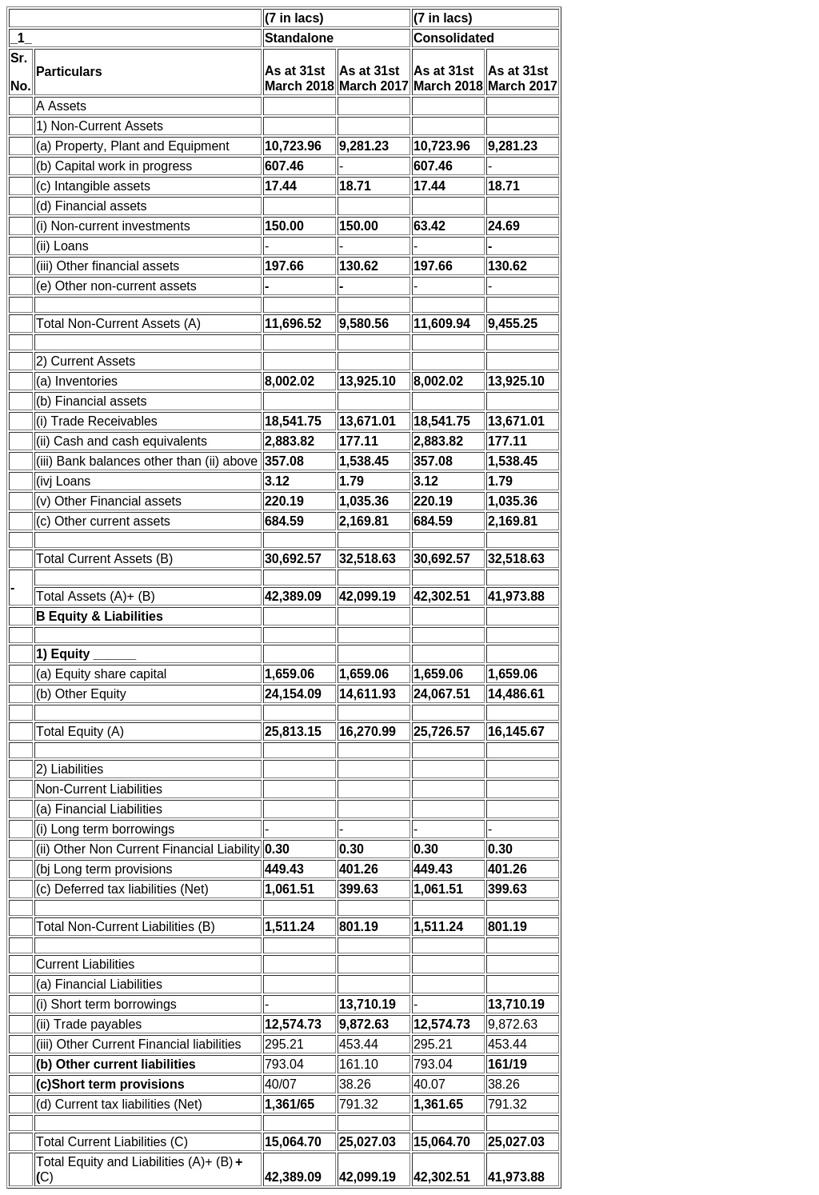

In [17]:
image_paths = sorted(list(Path("images").glob("*/*")))

image = Image.open(image_paths[0]).convert("RGB")
image

## EasyOCR

In [18]:
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [19]:
%%time
image_path = image_paths[0]
ocr_result = reader.readtext(str(image_path))

CPU times: user 27 s, sys: 3.78 s, total: 30.8 s
Wall time: 31.3 s


In [20]:
ocr_result[0]

([[279, 13], [327, 13], [327, 27], [279, 27]], 'In lacs)', 0.4307131980323542)

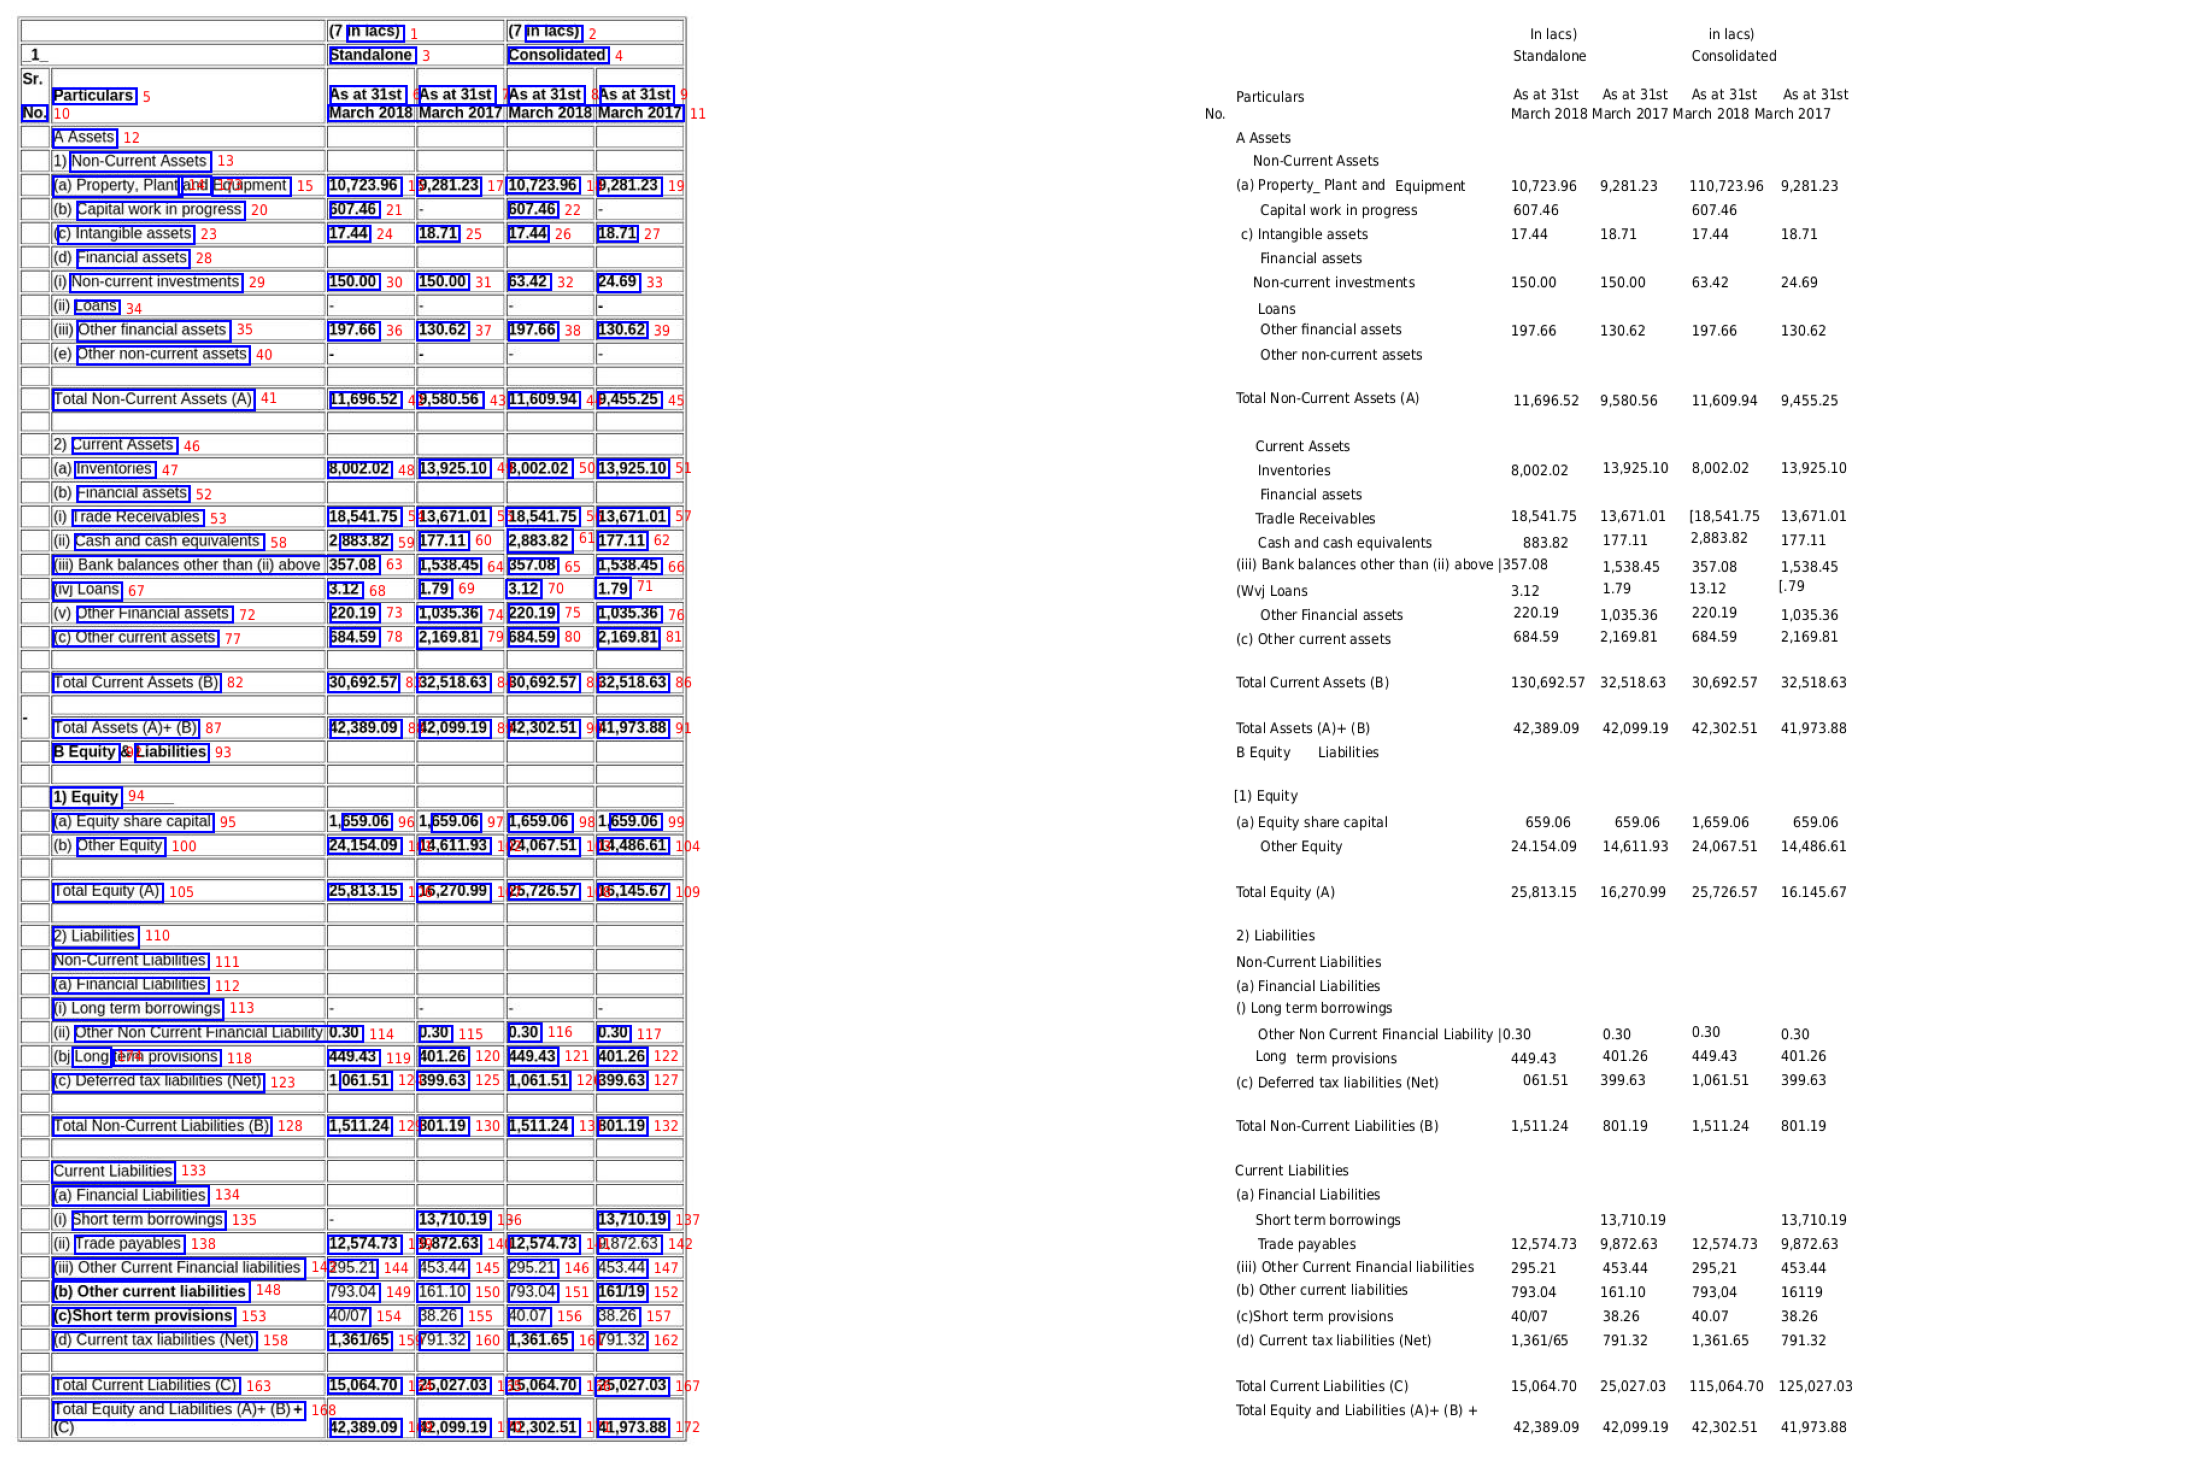

In [21]:
def create_bounding_box(bbox_data):
    xs = []
    ys = []
    for x, y in bbox_data:
        xs.append(x)
        ys.append(y)

    left = int(min(xs))
    top = int(min(ys))
    right = int(max(xs))
    bottom = int(max(ys))

    return [left, top, right, bottom]

font_path = Path(cv2.__path__[0]) / "qt/fonts/DejaVuSansCondensed.ttf"
font = ImageFont.truetype(str(font_path), size=12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 28))

left_image = Image.open(image_path).convert("RGB")
right_image = Image.new("RGB", left_image.size, (255, 255, 255))

left_draw = ImageDraw.Draw(left_image)
right_draw = ImageDraw.Draw(right_image)

for i, (bbox, word, confidence) in enumerate(ocr_result):
    box = create_bounding_box(bbox)

    left_draw.rectangle(box, outline="blue", width=2)
    left, top, right, bottom = box

    left_draw.text((right + 5, top), text=str(i + 1), fill="red", font=font)
    right_draw.text((left, top), text=word, fill="black", font=font)

ax1.imshow(left_image)
ax2.imshow(right_image)
ax1.axis("off");
ax2.axis("off");

In [ ]:
for image_path in tqdm(image_paths):
    ocr_result = reader.readtext(str(image_path), batch_size=16)

    ocr_page = []
    for bbox, word, confidence in ocr_result:
        ocr_page.append({
            "word": word, "bounding_box": create_bounding_box(bbox)
        })
    print(ocr_page)
    break
    # with image_path.with_suffix(".json").open("w") as f:
    #  json.dump(ocr_page, f)

In [ ]:
ocr_page[3]

In [28]:
!gdown 1bQ4mFbVRUtOEJSe8b4hUYIcngSgfdldw
!tar -xf financial-documents-ocr.tar.xz

Downloading...
From (original): https://drive.google.com/uc?id=1bQ4mFbVRUtOEJSe8b4hUYIcngSgfdldw
From (redirected): https://drive.google.com/uc?id=1bQ4mFbVRUtOEJSe8b4hUYIcngSgfdldw&confirm=t&uuid=c93bafcf-c9f0-4d37-9998-445109601571
To: /content/financial-documents-ocr.tar.xz
100% 147M/147M [00:02<00:00, 50.0MB/s]


In [31]:
image_paths = sorted(list(Path("images").glob("*/*.jpg")))
len(image_paths)

2573

## Preprocessing

In [ ]:
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained(
    "microsoft/layoutlmv3-base"
)
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

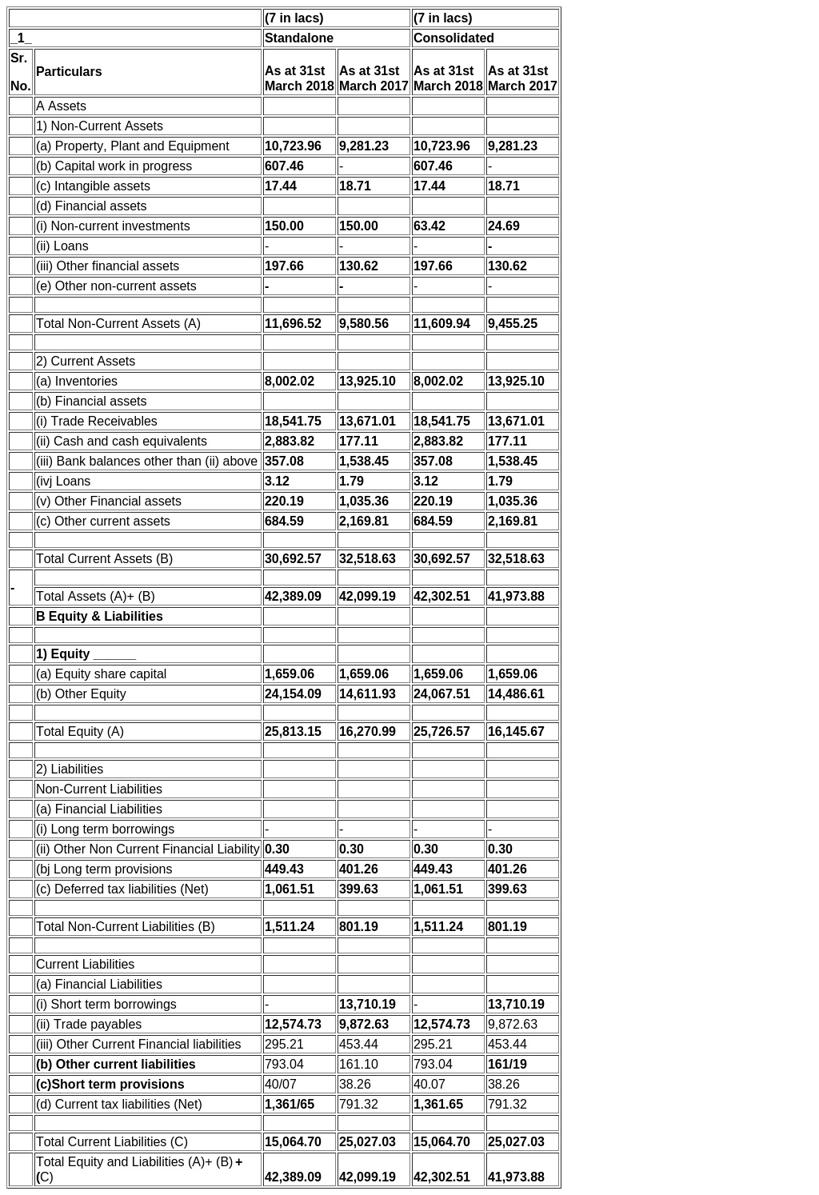

In [33]:
image = Image.open(image_paths[0]).convert("RGB")
image

In [35]:
image.size

(819, 1195)

In [36]:
image_path = image_paths[0]
image = Image.open(image_path).convert("RGB")
width, height = image.size

width_scale = 1000 / width
height_scale = 1000 / height

In [37]:
json_path = image_path.with_suffix(".json")
json_path

PosixPath('images/balance_sheets/18320959_3.json')

In [39]:
with json_path.open("r") as f:
  ocr_result = json.load(f)
len(ocr_result)

174

In [40]:
ocr_result[0]

{'word': 'In lacs)', 'bounding_box': [279, 13, 327, 27]}

In [42]:
def scale_bounding_box(box: List[int], width_scale : float = 1.0, height_scale : float = 1.0) -> List[int]:
    return [
        int(box[0] * width_scale),
        int(box[1] * height_scale),
        int(box[2] * width_scale),
        int(box[3] * height_scale)
    ]

In [43]:
words = []
boxes = []
for row in ocr_result:
    boxes.append(scale_bounding_box(row["bounding_box"], width_scale, height_scale))
    words.append(row["word"])

len(ocr_result), len(words), len(boxes)

(174, 174, 174)

In [44]:
encoding = processor(
    image,
    words,
    boxes=boxes,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

print(f"""
input_ids:  {list(encoding["input_ids"].squeeze().shape)}
word boxes: {list(encoding["bbox"].squeeze().shape)}
image data: {list(encoding["pixel_values"].squeeze().shape)}
image size: {image.size}
""")


input_ids:  [512]
word boxes: [512, 4]
image data: [3, 224, 224]
image size: (819, 1195)



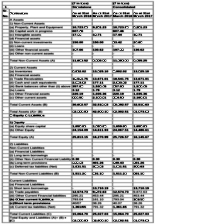

In [46]:
image_data = encoding["pixel_values"][0]
transform = T.ToPILImage()
transform(image_data)

In [48]:
image_data.shape

torch.Size([3, 224, 224])